In [16]:
# Standard libraries
import sys
# Add your custom path
gems_tco_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/src"
sys.path.append(gems_tco_path)
import os
import logging
import argparse # Argument parsing

# Data manipulation and analysis
import pandas as pd
import numpy as np
import pickle
import torch
import torch.optim as optim
import copy                    # clone tensor
import time

# Custom imports

from GEMS_TCO import kernels_reparam_space_time_gpu as kernels_reparam_space_time
from GEMS_TCO import orderings as _orderings 
from GEMS_TCO import alg_optimization, BaseLogger

from typing import Optional, List, Tuple
from pathlib import Path
import typer
import json
from json import JSONEncoder
from GEMS_TCO import configuration as config
from GEMS_TCO.data_loader import load_data2, exact_location_filter
from GEMS_TCO import debiased_whittle
from torch.nn import Parameter

# Investigate Spatial Stationarity

Given ```Longitude E110 to E120, Latitude N5 to N10```, create two hash maps for                                
```(West: Longitude E110 to E115, East: Longitude Longitude E115 to E120)```      
and then another two maps for                           
```(North:Latitude N5 to N7.5, South:Latitude N7.5 to N10)```.      

# Summary

Both plots on January 2023, and July 2024 shows that the GEMS ozone process is anisotropic and this has to be reflected in modeling.

### Create and save plots of semivariograms and variances from January 2023 to December 2024.

In [15]:
space: List[str] = ['1', '1']
lat_lon_resolution = [int(s) for s in space]
mm_cond_number: int = 8
years = ['2024']
month_range = [7] 

output_path = input_path = Path(config.mac_estimates_day_path)
data_load_instance = load_data2(config.mac_data_load_path)

#lat_range_input = [1, 3]
#lon_range_input = [125.0, 129.0]

lat_range_input=[-3,2]      
lon_range_input=[121, 131] 

df_map, ord_mm, nns_map = data_load_instance.load_maxmin_ordered_data_bymonthyear(
lat_lon_resolution=lat_lon_resolution, 
mm_cond_number=mm_cond_number,
years_=years, 
months_=month_range,

lat_range=lat_range_input,   
lon_range=lon_range_input
  
)


daily_aggregated_tensors_dw = [] 
daily_hourly_maps_dw = []      

daily_aggregated_tensors_vecc = [] 
daily_hourly_maps_vecc = []   


for day_index in range(31):
    hour_start_index = day_index * 8
    hour_end_index = (day_index + 1) * 8
    #hour_end_index = day_index*8 + 1
    hour_indices = [hour_start_index, hour_end_index]

    day_hourly_map, day_aggregated_tensor = data_load_instance.load_working_data(
    df_map, 
    hour_indices, 
    ord_mm= None,  # or just omit it
    dtype=torch.float64, # or just omit it 
    keep_ori=False  #keep_exact_loc
    )

    daily_aggregated_tensors_dw.append( day_aggregated_tensor )
    daily_hourly_maps_dw.append( day_hourly_map )

    day_hourly_map, day_aggregated_tensor = data_load_instance.load_working_data(
    df_map, 
    hour_indices, 
    ord_mm= ord_mm,  # or just omit it
    dtype=torch.float64, # or just omit it 
    keep_ori=False  #keep_exact_loc
    )

    daily_aggregated_tensors_vecc.append( day_aggregated_tensor )
    daily_hourly_maps_vecc.append( day_hourly_map )
print(daily_aggregated_tensors_vecc[0].shape)
#print(daily_hourly_maps[0])
nn = daily_aggregated_tensors_vecc[0].shape[0]

torch.Size([145008, 4])


Preparing Data...
Processing Region: North...
Processing Region: South...
Processing Region: West...
Processing Region: East...
Aggregating results...


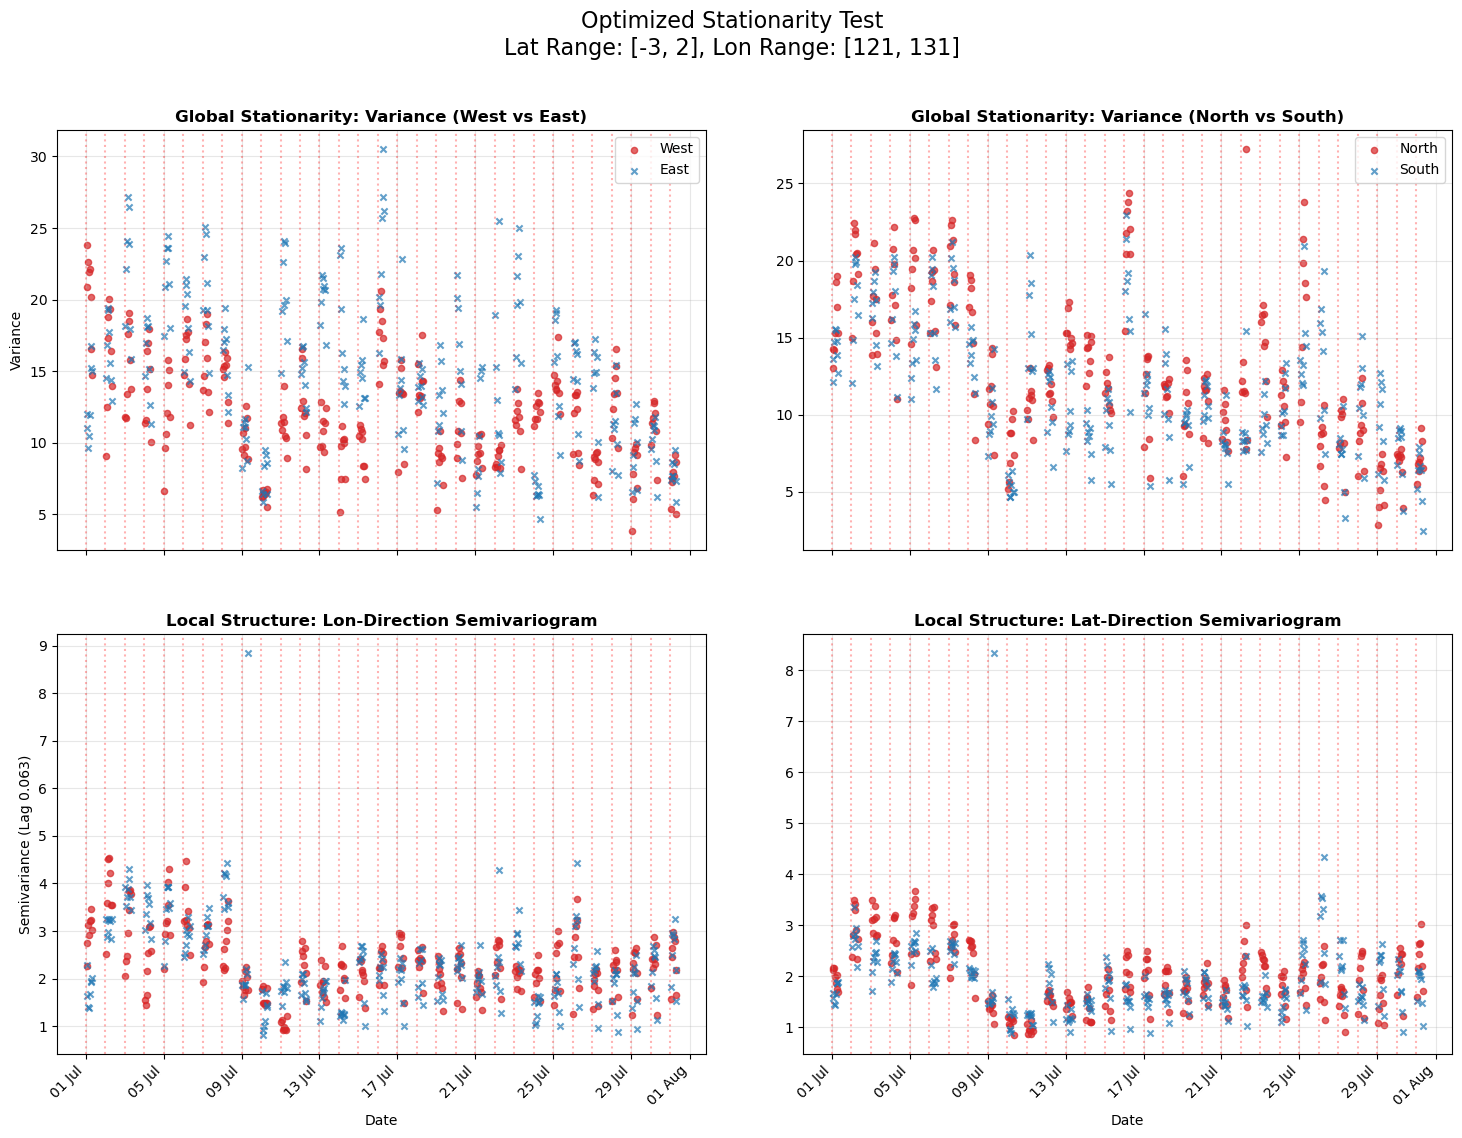

                 Date  North_Variance  North_Semi_LatDir  North_Semi_LonDir
0 2024-07-01 00:53:00       13.025514           2.167282           2.551190
1 2024-07-01 01:53:00       14.273416           2.127133           2.406739
2 2024-07-01 02:53:00       14.221819           2.151073           2.581967
3 2024-07-01 03:53:00       15.322497           1.974389           2.373367
4 2024-07-01 04:48:00       18.580400           1.862051           2.503154


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import torch

# --- Configuration ---
LAT_RANGE = [-3, 2]
LON_RANGE = [121, 131]
TOLERANCE = 0.02

# Directional Deltas (Lat_Diff, Lon_Diff)
# 1. Latitude Direction: Distance 0.044 (moving in Lat, 0 in Lon)
# 2. Longitude Direction: Distance 0.063 (moving in Lon, 0 in Lat)
DELTAS = [
    (0.044, 0.0),  # Latitudinal Semivariogram
    (0.0, 0.063)   # Longitudinal Semivariogram
]

# Calculate Midpoints
lat_mid = np.mean(LAT_RANGE) # -0.5
lon_mid = np.mean(LON_RANGE) # 126.0

# Define Regions
regions_bounds = {
    'North': {'lat': [lat_mid, LAT_RANGE[1]], 'lon': LON_RANGE},
    'South': {'lat': [LAT_RANGE[0], lat_mid], 'lon': LON_RANGE},
    'West':  {'lat': LAT_RANGE, 'lon': [LON_RANGE[0], lon_mid]},
    'East':  {'lat': LAT_RANGE, 'lon': [lon_mid, LON_RANGE[1]]}
}

# --- The Optimized Class (Using PyTorch for Speed) ---

class FastVariogram:
    def __init__(self, tolerance):
        self.tolerance = tolerance
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def compute_for_region(self, region_name, map_arrays, sorted_keys, deltas):
        """
        Computes semivariance for a specific region dict of arrays.
        map_arrays: dict {key: np.array of shape (N, 3)} -> [Lat, Lon, Val]
        """
        results = {}
        
        if not sorted_keys:
            return results

        # 1. Geometry Setup (Run ONCE using the first orbit)
        # We assume the grid structure is constant across orbits for this optimization
        first_key = sorted_keys[0]
        first_data = map_arrays[first_key]
        
        # Move coordinates to GPU/Tensor
        # coords shape: (N, 2) -> Lat, Lon
        coords_t = torch.tensor(first_data[:, :2], device=self.device, dtype=torch.float32)
        
        # Pre-compute indices for each delta
        delta_indices_cache = []
        
        # Calculate Difference Matrices (N x N)
        # Warning: If N > 15,000, this might require blocking to fit in GPU memory. 
        # For ~18k points (float32), one matrix is ~1.3GB. Doable on most GPUs.
        lat_diffs = coords_t[:, None, 0] - coords_t[None, :, 0]
        lon_diffs = coords_t[:, None, 1] - coords_t[None, :, 1]
        
        for (delta_lat, delta_lon) in deltas:
            # Create mask for this specific lag vector
            mask = (torch.abs(lat_diffs - delta_lat) <= self.tolerance) & \
                   (torch.abs(lon_diffs - delta_lon) <= self.tolerance)
            
            # Get valid indices
            pairs = torch.nonzero(mask, as_tuple=True)
            delta_indices_cache.append(pairs)
            
        # Cleanup memory
        del lat_diffs, lon_diffs, mask, coords_t
        if self.device == 'cuda':
            torch.cuda.empty_cache()
            
        # 2. Fast Analysis Loop
        for key in sorted_keys:
            current_data = map_arrays[key]
            
            # Safe check: if data length changed, optimization fails. Skip or resize.
            if len(current_data) != len(first_data):
                results[key] = [np.nan] * len(deltas)
                continue

            vals = torch.tensor(current_data[:, 2], device=self.device, dtype=torch.float32)
            # Center values (optional, but standard for semivariance calculation usually uses raw differences)
            # If you want pure structural semivariance:
            # vals = vals - torch.mean(vals) 
            
            orbit_res = []
            
            for (idx_row, idx_col) in delta_indices_cache:
                if len(idx_row) == 0:
                    orbit_res.append(np.nan)
                    continue
                
                # Vectorized Semivariance: 0.5 * mean((Zi - Zj)^2)
                diffs = vals[idx_col] - vals[idx_row]
                semivariance = 0.5 * torch.mean(diffs ** 2)
                orbit_res.append(semivariance.item())
                
            results[key] = orbit_res
            
        return results

# --- preprocessing: Convert DF_Map to Numpy Arrays per Region ---

def prepare_data(df_map, bounds):
    """
    Splits df_map into a clean dictionary of numpy arrays for a specific region.
    Returns: {key: np.array([[lat, lon, val], ...])}
    """
    arr_map = {}
    valid_keys = []
    
    sorted_keys = sorted(df_map.keys())
    
    for key in sorted_keys:
        df = df_map[key]
        
        # Region Filter
        mask = (
            (df['Latitude'] >= bounds['lat'][0]) & 
            (df['Latitude'] <= bounds['lat'][1]) & 
            (df['Longitude'] >= bounds['lon'][0]) & 
            (df['Longitude'] <= bounds['lon'][1])
        )
        sub_df = df[mask]
        
        if len(sub_df) < 10:
            continue
            
        # Ensure we sort by index or lat to maintain consistent order for matrix logic
        # (Though matrix logic relies on values, implicit ordering helps if debugging)
        sub_df = sub_df.sort_values(['Latitude', 'Longitude'])
        
        # Extract numpy array: Lat, Lon, O3
        arr = sub_df[['Latitude', 'Longitude', 'ColumnAmountO3']].values.astype(np.float32)
        
        arr_map[key] = arr
        valid_keys.append(key)
        
    return arr_map, valid_keys

# --- Execution ---

print("Preparing Data...")
processor = FastVariogram(tolerance=TOLERANCE)
final_stats = []

sorted_keys = sorted(df_map.keys())

# We need a master loop over keys to combine results later, 
# but the calculation happens per region.
region_results = {}

for r_name, r_bounds in regions_bounds.items():
    print(f"Processing Region: {r_name}...")
    
    # 1. Prepare Arrays
    r_map, r_keys = prepare_data(df_map, r_bounds)
    
    # 2. Compute Variograms (Vectorized)
    # returns dict: {key: [Lat_Semivariance, Lon_Semivariance]}
    r_stats = processor.compute_for_region(r_name, r_map, r_keys, DELTAS)
    
    # 3. Calculate Variance (Standard) while we are at it
    r_variances = {}
    for k in r_keys:
        r_variances[k] = np.var(r_map[k][:, 2])
        
    region_results[r_name] = {'semivariance': r_stats, 'variance': r_variances}

print("Aggregating results...")

# Consolidate into DataFrame
rows = []
for key in sorted_keys:
    # Get timestamp from original df
    if df_map[key].empty: continue
    ts = pd.to_datetime(df_map[key]['Time'].iloc[0])
    
    row = {'Key': key, 'Date': ts}
    
    for r_name in regions_bounds:
        # Check if we have results for this key in this region
        res = region_results[r_name]
        
        if key in res['semivariance']:
            # Variance
            row[f'{r_name}_Variance'] = res['variance'][key]
            
            # Semivariances [Lat_Dir, Lon_Dir]
            # Index 0 is DELTAS[0] -> Lat Direction (0.044)
            # Index 1 is DELTAS[1] -> Lon Direction (0.063)
            semis = res['semivariance'][key]
            row[f'{r_name}_Semi_LatDir'] = semis[0]
            row[f'{r_name}_Semi_LonDir'] = semis[1]
        else:
            row[f'{r_name}_Variance'] = np.nan
            row[f'{r_name}_Semi_LatDir'] = np.nan
            row[f'{r_name}_Semi_LonDir'] = np.nan
            
    rows.append(row)

stats_df = pd.DataFrame(rows)

# --- Plotting ---

fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharex=True)
plt.subplots_adjust(hspace=0.2, wspace=0.15)

colors = {'North': '#d62728', 'South': '#1f77b4', 'West': '#d62728', 'East': '#1f77b4'}
markers = {'North': 'o', 'South': 'x', 'West': 'o', 'East': 'x'}

# Plot 1: Longitudinal Stationarity (Variance West vs East)
ax = axes[0, 0]
for r in ['West', 'East']:
    ax.scatter(stats_df['Date'], stats_df[f'{r}_Variance'], 
               label=r, c=colors[r], marker=markers[r], s=20, alpha=0.7)
ax.set_title('Global Stationarity: Variance (West vs East)', fontweight='bold')
ax.set_ylabel('Variance')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Latitudinal Stationarity (Variance North vs South)
ax = axes[0, 1]
for r in ['North', 'South']:
    ax.scatter(stats_df['Date'], stats_df[f'{r}_Variance'], 
               label=r, c=colors[r], marker=markers[r], s=20, alpha=0.7)
ax.set_title('Global Stationarity: Variance (North vs South)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Semivariogram in Longitude Direction (Lag ~0.063)
ax = axes[1, 0]
for r in ['West', 'East']:
    col = f'{r}_Semi_LonDir'
    ax.scatter(stats_df['Date'], stats_df[col], 
               label=f"{r} (Lag 0.063)", c=colors[r], marker=markers[r], s=20, alpha=0.7)
ax.set_title('Local Structure: Lon-Direction Semivariogram', fontweight='bold')
ax.set_ylabel('Semivariance (Lag 0.063)')
ax.set_xlabel('Date')
ax.grid(True, alpha=0.3)

# Plot 4: Semivariogram in Latitude Direction (Lag ~0.044)
ax = axes[1, 1]
for r in ['North', 'South']:
    col = f'{r}_Semi_LatDir'
    ax.scatter(stats_df['Date'], stats_df[col], 
               label=f"{r} (Lag 0.044)", c=colors[r], marker=markers[r], s=20, alpha=0.7)
ax.set_title('Local Structure: Lat-Direction Semivariogram', fontweight='bold')
ax.set_xlabel('Date')
ax.grid(True, alpha=0.3)

# Formatting
unique_days = stats_df['Date'].dt.date.unique()
for ax in axes.flat:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    for day in unique_days:
        ax.axvline(pd.Timestamp(day), color='r', linestyle=':', alpha=0.3)

plt.suptitle(f'Optimized Stationarity Test\nLat Range: {LAT_RANGE}, Lon Range: {LON_RANGE}', fontsize=16)
plt.show()

print(stats_df[['Date', 'North_Variance', 'North_Semi_LatDir', 'North_Semi_LonDir']].head())

let's do this after differencing

Generating difference_map...
Difference Map created. Processed 248 / 248 orbits.


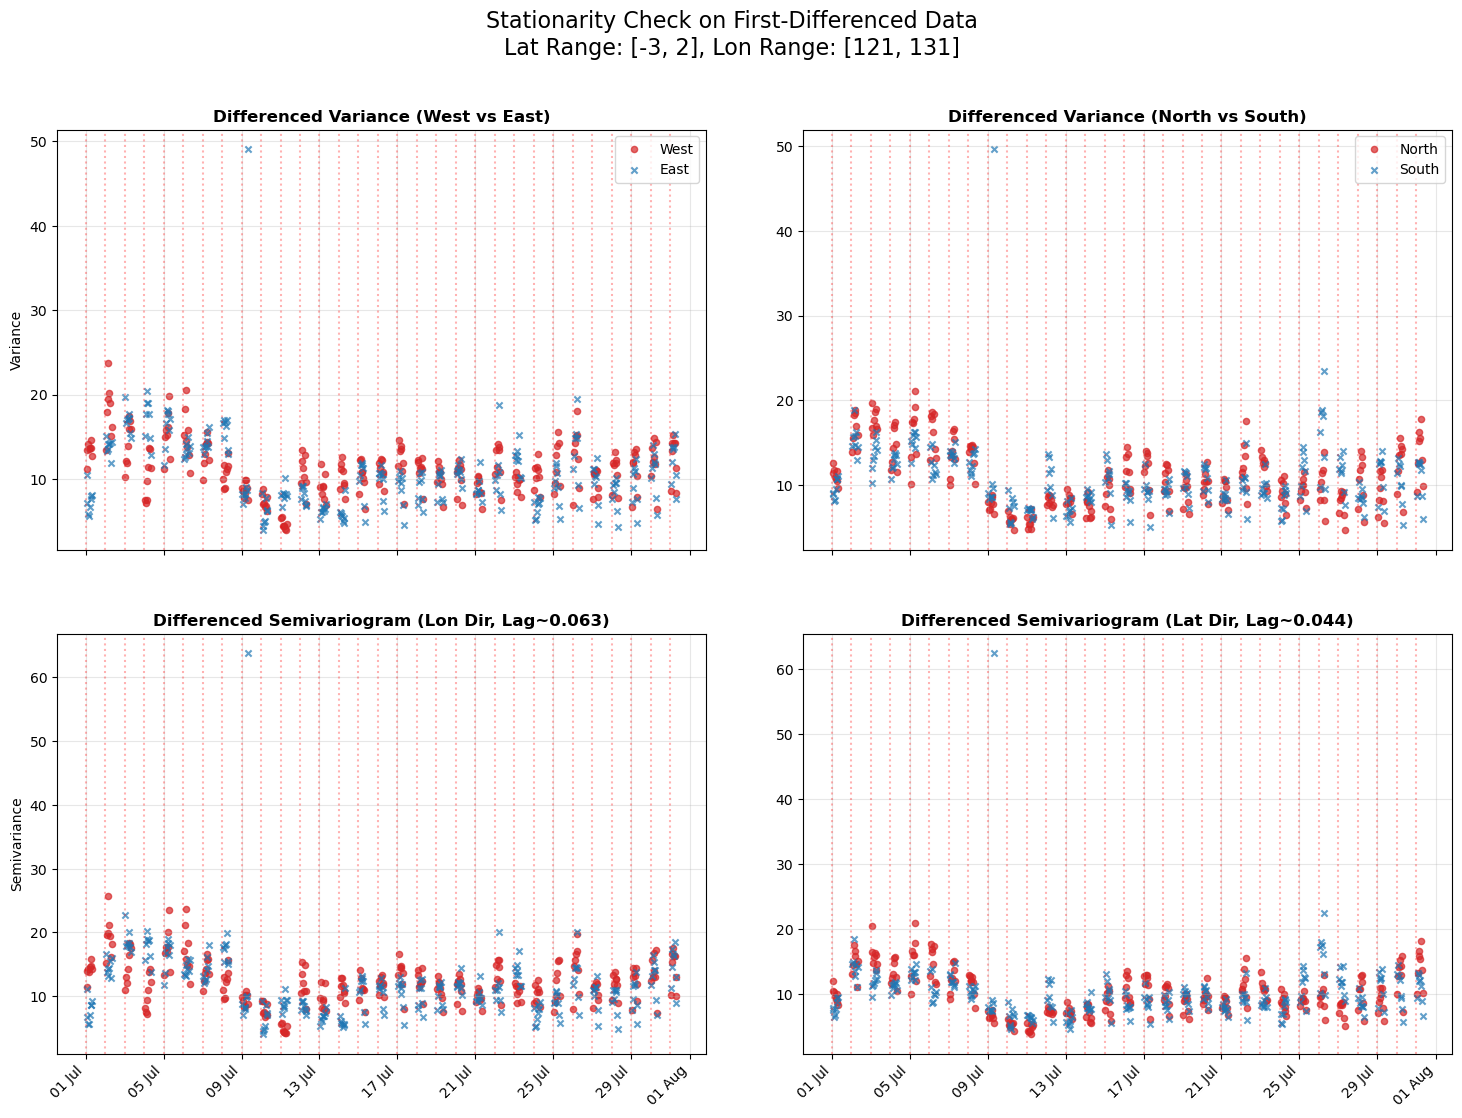

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import torch
import torch.nn.functional as F

# --- 1. Corrected Differencing Function ---

def apply_first_difference_2d_tensor(df_tensor: torch.Tensor) -> torch.Tensor:
    """
    Applies a 2D first-order difference filter using convolution.
    Kernel: Z(i,j) = X(i+1,j) + X(i,j+1) - 2*X(i,j)
    """
    if df_tensor.size(0) == 0:
        return torch.empty(0, 4, dtype=torch.float64)
    
    # Force input to float64
    if df_tensor.dtype != torch.float64:
        df_tensor = df_tensor.to(torch.float64)

    # 1. Get grid dimensions
    unique_lats = torch.unique(df_tensor[:, 0])
    unique_lons = torch.unique(df_tensor[:, 1])
    lat_count, lon_count = unique_lats.size(0), unique_lons.size(0)

    # Validate Grid
    if df_tensor.size(0) != lat_count * lon_count:
        # If data is not a perfect grid, return empty or handle error
        raise ValueError(f"Tensor size {df_tensor.size(0)} does not match grid {lat_count}x{lon_count}")
        
    if lat_count < 2 or lon_count < 2:
        return torch.empty(0, 4)

    # 2. Reshape data (Batched as 1, 1, H, W for conv2d)
    # --- FIX START: Replace lexsort with chained argsort ---
    # To sort by (Lat, Lon), we perform stable sorts in reverse order:
    # First sort by secondary key (Longitude)
    indices_lon = torch.argsort(df_tensor[:, 1], stable=True)
    df_tensor = df_tensor[indices_lon]
    
    # Then sort by primary key (Latitude)
    indices_lat = torch.argsort(df_tensor[:, 0], stable=True)
    df_tensor = df_tensor[indices_lat]
    # --- FIX END ---
    
    # Now reshape: (Batch, Channel, Lat, Lon)
    ozone_data = df_tensor[:, 2].reshape(1, 1, lat_count, lon_count)
    
    # 3. Define Kernel
    diff_kernel = torch.tensor([[[[-2., 1.],
                                [ 1., 0.]]]], dtype=torch.float64)
    diff_kernel = diff_kernel.to(df_tensor.device)
    
    # 4. Apply Convolution
    filtered_grid = F.conv2d(ozone_data, diff_kernel, padding='valid').squeeze()

    # 5. Reconstruct Output
    # The output grid size is (H-1) x (W-1)
    new_lats = unique_lats[:-1]
    new_lons = unique_lons[:-1]

    new_lat_grid, new_lon_grid = torch.meshgrid(new_lats, new_lons, indexing='ij')
    filtered_values = filtered_grid.flatten()
    
    # Use the time from the first row
    time_value = df_tensor[0, 3].repeat(filtered_values.size(0))

    new_tensor = torch.stack([
        new_lat_grid.flatten(),
        new_lon_grid.flatten(),
        filtered_values,
        time_value
    ], dim=1)
    
    return new_tensor

# --- 2. Execution Logic (Data Processing & Visualization) ---
# Assuming df_map is already loaded in your environment

print("Generating difference_map...")
difference_map = {}
sorted_keys = sorted(df_map.keys())
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for key in sorted_keys:
    df = df_map[key]
    
    # Convert Time to numeric timestamp
    if not pd.api.types.is_numeric_dtype(df['Time']):
        time_vals = pd.to_datetime(df['Time']).astype(np.int64) // 10**9 
    else:
        time_vals = df['Time']

    input_data = df[['Latitude', 'Longitude', 'ColumnAmountO3']].values
    time_col = time_vals.values.reshape(-1, 1)
    
    tensor_data = torch.tensor(np.hstack([input_data, time_col]), device=device, dtype=torch.float64)
    
    try:
        diff_tensor = apply_first_difference_2d_tensor(tensor_data)
        
        if diff_tensor.size(0) > 0:
            res_np = diff_tensor.cpu().numpy()
            new_df = pd.DataFrame(res_np, columns=['Latitude', 'Longitude', 'ColumnAmountO3', 'Time'])
            new_df['Time'] = pd.to_datetime(new_df['Time'], unit='s')
            difference_map[key] = new_df
            
    except ValueError:
        # Skip incomplete grids silently
        pass

print(f"Difference Map created. Processed {len(difference_map)} / {len(df_map)} orbits.")

# --- 3. Run Stationarity Analysis on Difference Map ---

LAT_RANGE = [-3, 2]
LON_RANGE = [121, 131]
TOLERANCE = 0.02
DELTAS = [(0.044, 0.0), (0.0, 0.063)]

# Midpoints
lat_mid = np.mean(LAT_RANGE) # -0.5
lon_mid = np.mean(LON_RANGE) # 126.0

regions_bounds = {
    'North': {'lat': [lat_mid, LAT_RANGE[1]], 'lon': LON_RANGE},
    'South': {'lat': [LAT_RANGE[0], lat_mid], 'lon': LON_RANGE},
    'West':  {'lat': LAT_RANGE, 'lon': [LON_RANGE[0], lon_mid]},
    'East':  {'lat': LAT_RANGE, 'lon': [lon_mid, LON_RANGE[1]]}
}

class FastVariogram:
    def __init__(self, tolerance):
        self.tolerance = tolerance
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def compute_for_region(self, region_name, map_arrays, sorted_keys, deltas):
        results = {}
        if not sorted_keys: return results

        first_key = sorted_keys[0]
        first_data = map_arrays[first_key]
        coords_t = torch.tensor(first_data[:, :2], device=self.device, dtype=torch.float32)
        
        delta_indices_cache = []
        lat_diffs = coords_t[:, None, 0] - coords_t[None, :, 0]
        lon_diffs = coords_t[:, None, 1] - coords_t[None, :, 1]
        
        for (delta_lat, delta_lon) in deltas:
            mask = (torch.abs(lat_diffs - delta_lat) <= self.tolerance) & \
                   (torch.abs(lon_diffs - delta_lon) <= self.tolerance)
            pairs = torch.nonzero(mask, as_tuple=True)
            delta_indices_cache.append(pairs)
            
        del lat_diffs, lon_diffs, mask, coords_t
        if self.device == 'cuda': torch.cuda.empty_cache()
            
        for key in sorted_keys:
            current_data = map_arrays[key]
            if len(current_data) != len(first_data):
                results[key] = [np.nan] * len(deltas)
                continue

            vals = torch.tensor(current_data[:, 2], device=self.device, dtype=torch.float32)
            
            orbit_res = []
            for (idx_row, idx_col) in delta_indices_cache:
                if len(idx_row) == 0:
                    orbit_res.append(np.nan)
                    continue
                diffs = vals[idx_col] - vals[idx_row]
                semivariance = 0.5 * torch.mean(diffs ** 2)
                orbit_res.append(semivariance.item())
                
            results[key] = orbit_res
        return results

def prepare_data(input_map, bounds):
    arr_map = {}
    valid_keys = []
    sorted_keys = sorted(input_map.keys())
    for key in sorted_keys:
        df = input_map[key]
        mask = ((df['Latitude'] >= bounds['lat'][0]) & (df['Latitude'] <= bounds['lat'][1]) & 
                (df['Longitude'] >= bounds['lon'][0]) & (df['Longitude'] <= bounds['lon'][1]))
        sub_df = df[mask]
        if len(sub_df) < 10: continue
        sub_df = sub_df.sort_values(['Latitude', 'Longitude'])
        arr = sub_df[['Latitude', 'Longitude', 'ColumnAmountO3']].values.astype(np.float32)
        arr_map[key] = arr
        valid_keys.append(key)
    return arr_map, valid_keys

processor = FastVariogram(tolerance=TOLERANCE)
region_results = {}

for r_name, r_bounds in regions_bounds.items():
    r_map, r_keys = prepare_data(difference_map, r_bounds)
    r_stats = processor.compute_for_region(r_name, r_map, r_keys, DELTAS)
    
    r_variances = {}
    for k in r_keys:
        r_variances[k] = np.var(r_map[k][:, 2])
        
    region_results[r_name] = {'semivariance': r_stats, 'variance': r_variances}

rows = []
for key in sorted(difference_map.keys()):
    ts = difference_map[key]['Time'].iloc[0]
    row = {'Key': key, 'Date': ts}
    
    for r_name in regions_bounds:
        res = region_results.get(r_name, {'semivariance': {}, 'variance': {}})
        if key in res['semivariance']:
            row[f'{r_name}_Variance'] = res['variance'][key]
            semis = res['semivariance'][key]
            row[f'{r_name}_Semi_LatDir'] = semis[0]
            row[f'{r_name}_Semi_LonDir'] = semis[1]
        else:
            for c in ['Variance', 'Semi_LatDir', 'Semi_LonDir']:
                row[f'{r_name}_{c}'] = np.nan
    rows.append(row)

stats_df = pd.DataFrame(rows)

fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharex=True)
plt.subplots_adjust(hspace=0.2, wspace=0.15)
colors = {'North': '#d62728', 'South': '#1f77b4', 'West': '#d62728', 'East': '#1f77b4'}
markers = {'North': 'o', 'South': 'x', 'West': 'o', 'East': 'x'}

ax = axes[0, 0]
for r in ['West', 'East']:
    ax.scatter(stats_df['Date'], stats_df[f'{r}_Variance'], label=r, c=colors[r], marker=markers[r], s=20, alpha=0.7)
ax.set_title('Differenced Variance (West vs East)', fontweight='bold')
ax.set_ylabel('Variance')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
for r in ['North', 'South']:
    ax.scatter(stats_df['Date'], stats_df[f'{r}_Variance'], label=r, c=colors[r], marker=markers[r], s=20, alpha=0.7)
ax.set_title('Differenced Variance (North vs South)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
for r in ['West', 'East']:
    ax.scatter(stats_df['Date'], stats_df[f'{r}_Semi_LonDir'], label=f"{r}", c=colors[r], marker=markers[r], s=20, alpha=0.7)
ax.set_title(f'Differenced Semivariogram (Lon Dir, Lag~{DELTAS[1][1]})', fontweight='bold')
ax.set_ylabel('Semivariance')
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
for r in ['North', 'South']:
    ax.scatter(stats_df['Date'], stats_df[f'{r}_Semi_LatDir'], label=f"{r}", c=colors[r], marker=markers[r], s=20, alpha=0.7)
ax.set_title(f'Differenced Semivariogram (Lat Dir, Lag~{DELTAS[0][0]})', fontweight='bold')
ax.grid(True, alpha=0.3)

unique_days = stats_df['Date'].dt.date.unique()
for ax in axes.flat:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    for day in unique_days:
        ax.axvline(pd.Timestamp(day), color='r', linestyle=':', alpha=0.3)

plt.suptitle(f'Stationarity Check on First-Differenced Data\nLat Range: {LAT_RANGE}, Lon Range: {LON_RANGE}', fontsize=16)
plt.show()


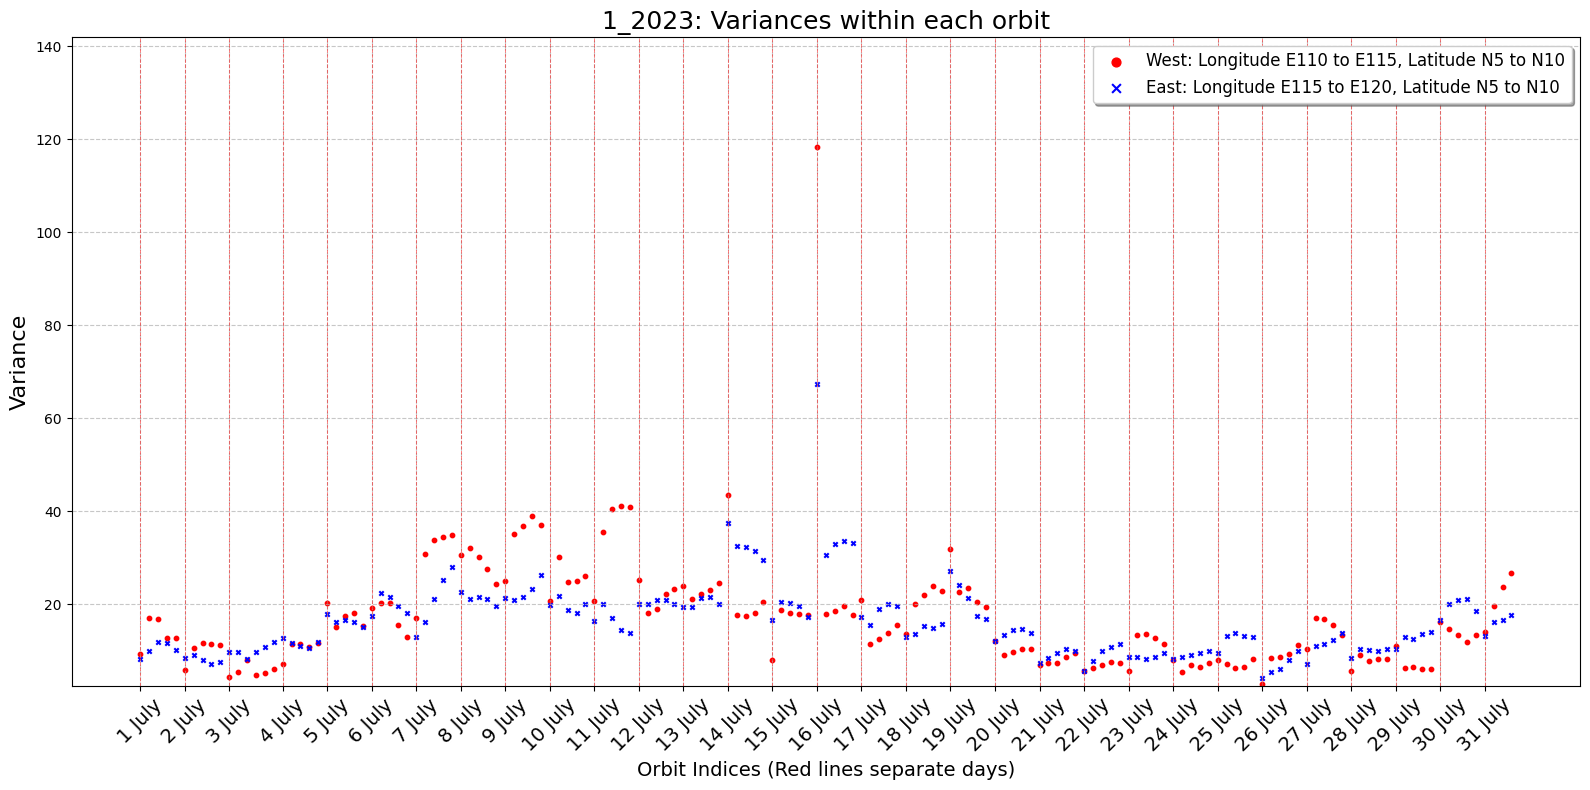

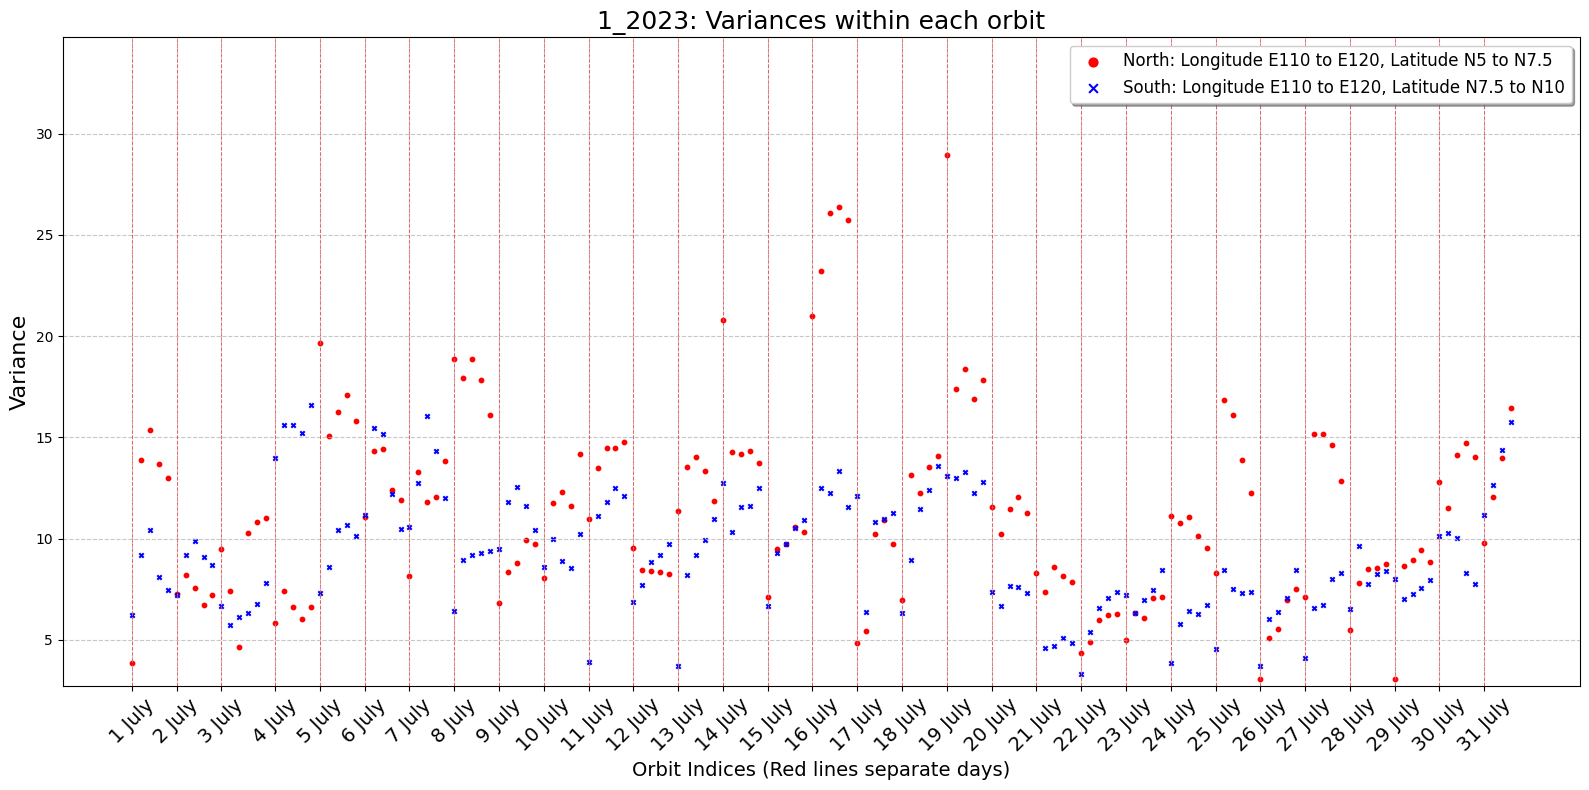

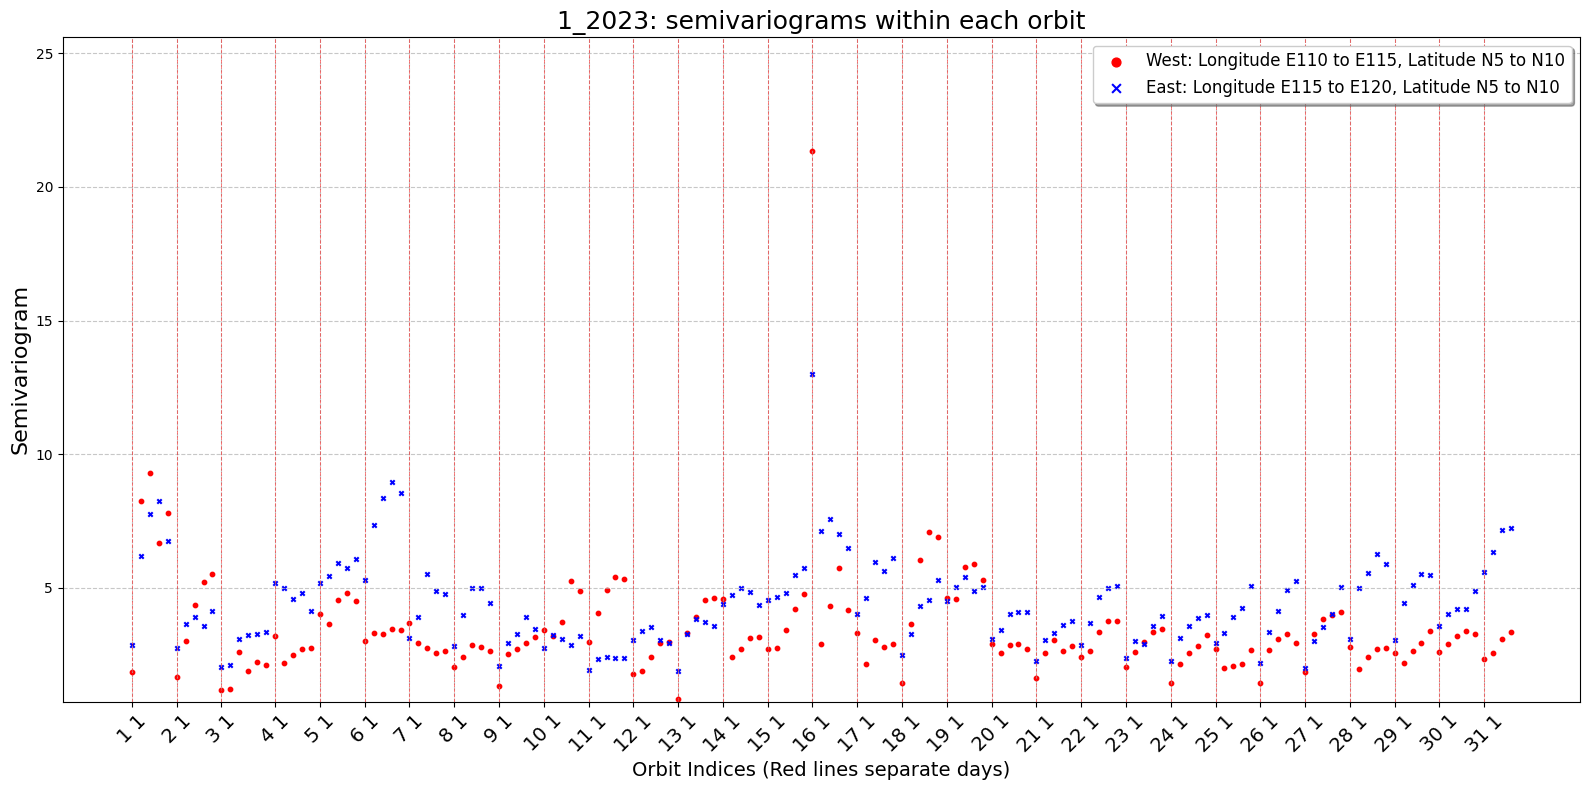

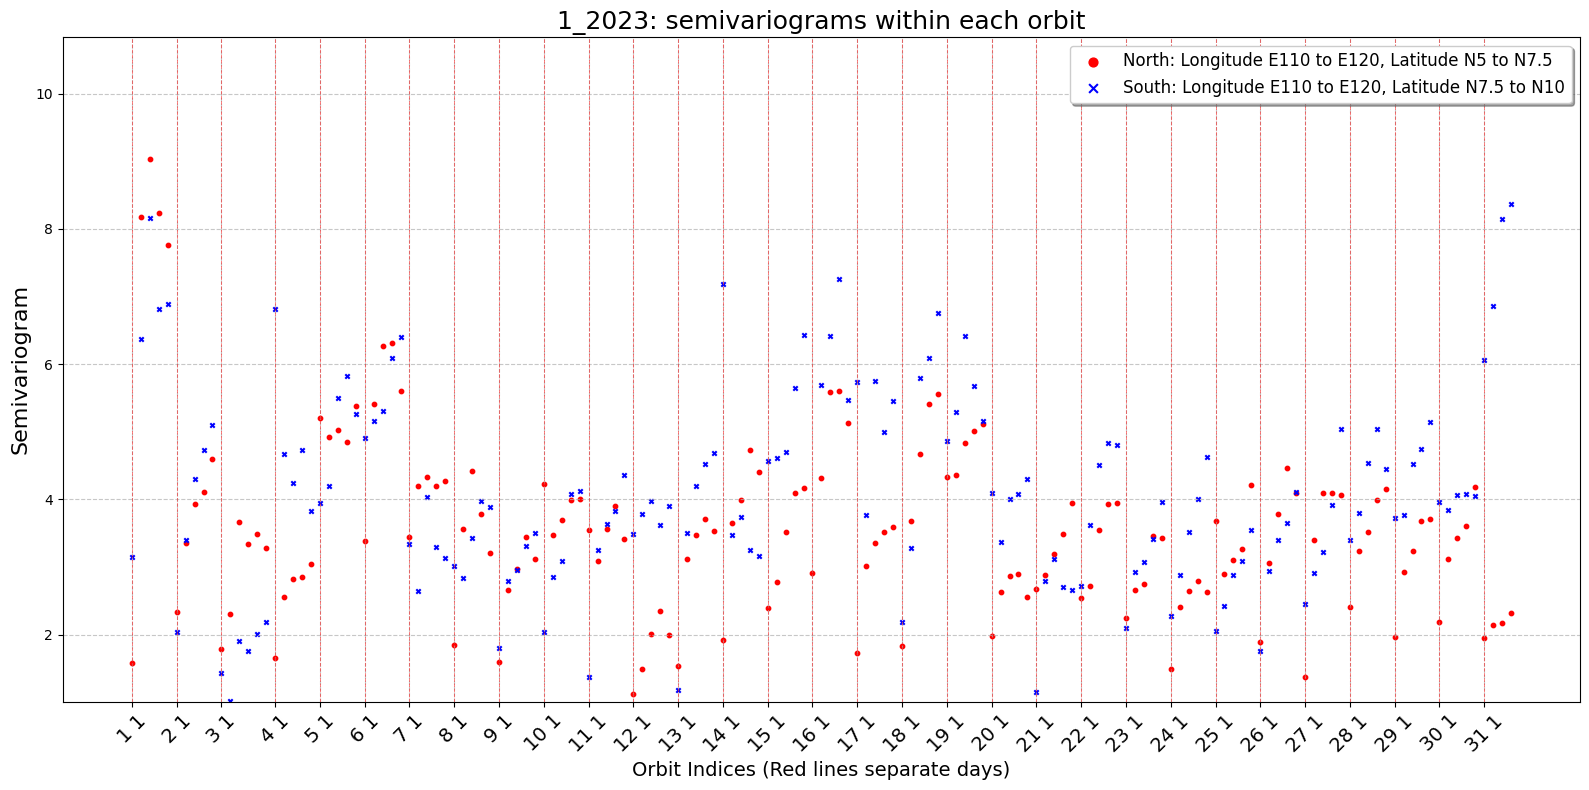

In [ ]:
for year in ['2023']:
    for month in range(1,2):
        filepath = f"C:\\Users\\joonw\\TCO\\GEMS_data\\data_{year}\\sparse_cen_map{year[2:]}_{month:02d}.pkl"
        with open(filepath, 'rb') as pickle_file:
            loaded_map = pickle.load(pickle_file)
        
        ''' 
        loaded_map should be a hash map that returns dataframe for 'year' and 'month'.
        '''

        instance_t = timeseries(loaded_map, year, month, output_dir)
        instance_t.save_data_plots()

We can expand to other months using loop below.

In [ ]:
for year in ['2023','2024']:
    for month in range(1,13):
        filepath = f"C:\\Users\\joonw\\TCO\\GEMS_data\\data_{year}\\sparse_cen_map{year[2:]}_{month:02d}.pkl"
        with open(filepath, 'rb') as pickle_file:
            loaded_map = pickle.load(pickle_file)
        
        ''' 
        loaded_map should be a hash map that returns dataframe for 'year' and 'month'.
        '''

        instance_t = timeseries(loaded_map, year, month, output_dir)
        instance_t.save_data_plots()

In [3]:
class timeseries:
    def __init__(self, map: dict, year: str, month: int, output_dir: str):
        self.map = map
        self.year = year
        self.month = month
        self.output_dir = output_dir

    def var_timeseries_month(self):
        var_timeseries = []

        # Generate variance and month markers
        for _, key in enumerate(self.map.keys()):
            cur = self.map[key]
            var_timeseries.append(np.var(cur['ColumnAmountO3']))

        return var_timeseries
     
    def sem_timeseries_month(self, sem_lag=0.2, tolerance=0.02):

        sem_timeseries = []
        sem_lag = 0.2
        tolerance = 0.02

        # Generate semivariograms and day markers
        for _, key in enumerate(self.map.keys()):
            cur = self.map[key]
            coordinates = np.array(cur[['Latitude', 'Longitude']])
            values = np.array(cur['ColumnAmountO3'])
            pairwise_distances = squareform(pdist(coordinates))
            valid_pairs = np.where((pairwise_distances >= sem_lag - tolerance) &
                                    (pairwise_distances <= sem_lag + tolerance))

            if len(valid_pairs[0]) == 0:
                sem_timeseries.append(np.nan)
                continue
            
            semivariances = 0.5 * np.mean((values[valid_pairs[0]] - values[valid_pairs[1]]) ** 2)
            sem_timeseries.append(semivariances)

        return sem_timeseries
    
    def map_separation(self):
        '''  
        this method creates 4 maps: West, East, North and South. 
        In this method, I clipped data ozone values between 150 and 300. 
        '''
        coarse_dict = {}
        for key in self.map:
            cur = self.map[key].copy()

            ## we need to remove outliars
            mask = (cur['ColumnAmountO3'] < 150) | (cur['ColumnAmountO3'] > 300)
            filtered_data = cur[~mask].reset_index(drop=True)

            # Handle cases where the filtered DataFrame is empty
            if filtered_data.empty:
                print(f"Warning: No valid data for key {key}. Skipping.")
                continue
            coarse_dict[key] = filtered_data

        coarse_map_left = {}
        coarse_map_right = {}
        coarse_map_north = {}
        coarse_map_south = {}

        keys = sorted(coarse_dict.keys())
        lat_s, lat_e, lon_s, lon_e = 5, 10, 110, 120
        mid_lon = np.mean([lon_s, lon_e])
        mid_lat = np.mean([lat_s, lat_e])

        
        for key in keys:
            data = coarse_dict[key]
            coarse_map_left[key] = data[data['Longitude'] <= mid_lon]
            coarse_map_right[key] = data[data['Longitude'] > mid_lon]
            coarse_map_north[key] = data[data['Latitude'] > mid_lat]
            coarse_map_south[key] = data[data['Latitude'] <= mid_lat]

        self.coarse_dict = coarse_dict

        return coarse_map_left,coarse_map_right,coarse_map_north,coarse_map_south

    def compute_sem_var(self):
        """
        Compute variances and semivariograms for spatially divided submaps.
        Most of the computation time will be spent here.
        """
        coarse_map_left,coarse_map_right,coarse_map_north,coarse_map_south = self.map_separation()
        coarse_maps = [coarse_map_left,coarse_map_right,coarse_map_north,coarse_map_south]
        sem_results=[]
        var_results = []

        for submap in coarse_maps:
            if not submap:  # Skip if submap is empty
                print(f"Warning: submap is empty. Skipping.")
                continue
            instance_s = timeseries(submap,self.year, self.month, self.output_dir)
            sem_results.append( list(instance_s.sem_timeseries_month(sem_lag=0.2, tolerance=0.02)))
            var_results.append(list(instance_s.var_timeseries_month()))

        return sem_results, var_results
    
    def save_data_plots(self):

        sem_results, var_results = self.compute_sem_var()

        sem1,sem2,sem3,sem4 = sem_results[0],sem_results[1],sem_results[2],sem_results[3]
        var1,var2,var3,var4 = var_results[0],var_results[1],var_results[2],var_results[3]

        var_sem_map = {}
        var_sem_map[f'{year}_{month}'] = pd.DataFrame({
            'west_sem': sem1, 
            'east_sem': sem2, 
            'north_sem': sem3, 
            'south_sem': sem4,
            'west_var': var1, 
            'east_var': var2, 
            'north_var': var3, 
            'south_var': var4,
        })

        ##### Save the dictionary to a pickle file
        filepath = os.path.join(self.output_dir,'var_sem_map.pkl')
        with open(filepath, 'wb') as pickle_file:
            pickle.dump(var_sem_map, pickle_file)

        ##### Save plots
        
        var_timeseries = []
        day_positions = [0]
        d_labels = ['1']
        prev_day = '01'

        # Generate variance and month markers
        for idx, key in enumerate(self.coarse_dict.keys()):
            cur = self.coarse_dict[key]
            var_timeseries.append(np.var(cur['ColumnAmountO3']))
            current_day = key[9:11]
            if current_day != prev_day:
                day_positions.append(idx)
                d_labels.append(f"{int(current_day)}")  
                prev_day = current_day

        # Generate orbit indices
        orbit_indices = range(len(var_timeseries))

        #### plot 1
        plot_file = os.path.join(self.output_dir, f"West_vs_East_variance_{self.year}_{self.month}.png")

        plt.figure(figsize=(16, 8))
        plt.scatter(orbit_indices, var1, marker='o', s=10, color='red', label="West: Longitude E110 to E115, Latitude N5 to N10")
        plt.scatter(orbit_indices, var2, marker='x', s=10, color='blue', label="East: Longitude E115 to E120, Latitude N5 to N10")

        # Add month separation lines
        for pos in day_positions:
            plt.axvline(x=pos, color='red', linestyle='--', linewidth=0.7, alpha=0.5)

        # Add X-ticks for days
        day_labels = [f"{label} {'July'}" for i, label in enumerate(d_labels)]
        plt.xticks(ticks=day_positions, labels=day_labels, fontsize=14, rotation=45)

        plt.xlabel('Orbit Indices (Red lines separate days)', fontsize=14)
        plt.ylabel('Variance', fontsize=16)
        plt.title(f'{self.month}_{self.year}: Variances within each orbit', fontsize=18)
        plt.ylim([min(var1)*0.9, max(var1) * 1.2])
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=12, markerscale=2, loc='upper right', frameon=True, shadow=True)
        plt.tight_layout()
        plt.savefig(plot_file)
        plt.show()

        #### plot 2
        # Save the plot as an image
        plot_file = os.path.join(self.output_dir, f"North_vs_South_variance_{self.year}_{self.month}.png")

        plt.figure(figsize=(16, 8))
        plt.scatter(orbit_indices, var3, marker='o', s=10, color='red', label="North: Longitude E110 to E120, Latitude N5 to N7.5")
        plt.scatter(orbit_indices, var4, marker='x', s=10, color='blue', label="South: Longitude E110 to E120, Latitude N7.5 to N10")

        # Add month separation lines
        for pos in day_positions:
            plt.axvline(x=pos, color='red', linestyle='--', linewidth=0.7, alpha=0.5)
        # Add X-ticks for days
        day_labels = [f"{label} {'July'}" for i, label in enumerate(d_labels)]
        plt.xticks(ticks=day_positions, labels=day_labels, fontsize=14, rotation=45)

        plt.xlabel('Orbit Indices (Red lines separate days)', fontsize=14)
        plt.ylabel('Variance', fontsize=16)
        plt.title(f'{self.month}_{self.year}: Variances within each orbit', fontsize=18)
        plt.ylim([min(var3)*0.9, max(var3) * 1.2])
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=12, markerscale=2, loc='upper right', frameon=True, shadow=True)
        plt.tight_layout()
        plt.savefig(plot_file)
        plt.show()

        ###############################################
        ###############################################

        #  Semivariograms
        #### plot 3
        plot_file = os.path.join(self.output_dir, f"West_vs_East_semivariogram_{self.year}_{self.month}.png")

        plt.figure(figsize=(16, 8))
        plt.scatter(orbit_indices, sem1, marker='o', s=10, color='red', label="West: Longitude E110 to E115, Latitude N5 to N10")
        plt.scatter(orbit_indices, sem2, marker='x', s=10, color='blue', label="East: Longitude E115 to E120, Latitude N5 to N10")

        # Add month separation lines
        for pos in day_positions:
            plt.axvline(x=pos, color='red', linestyle='--', linewidth=0.7, alpha=0.5)

        # Add X-ticks for days
        day_labels = [f"{label} {self.month}" for i, label in enumerate(d_labels)]
        plt.xticks(ticks=day_positions, labels=day_labels, fontsize=14, rotation=45)

        plt.xlabel('Orbit Indices (Red lines separate days)', fontsize=14)
        plt.ylabel('Semivariogram', fontsize=16)
        plt.title(f'{self.month}_{self.year}: semivariograms within each orbit', fontsize=18)
        plt.ylim([min(sem1)*0.9, max(sem1) * 1.2])
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=12, markerscale=2, loc='upper right', frameon=True, shadow=True)
        plt.tight_layout()
        plt.savefig(plot_file)
        plt.show()

        #### plot 4
        plot_file = os.path.join(self.output_dir, f"North_vs_South_semivariogram_{self.year}_{self.month}.png")
        plt.figure(figsize=(16, 8))
        plt.scatter(orbit_indices, sem3, marker='o', s=10, color='red', label="North: Longitude E110 to E120, Latitude N5 to N7.5")
        plt.scatter(orbit_indices, sem4, marker='x', s=10, color='blue', label="South: Longitude E110 to E120, Latitude N7.5 to N10")

        # Add month separation lines
        for pos in day_positions:
            plt.axvline(x=pos, color='red', linestyle='--', linewidth=0.7, alpha=0.5)

        # Add X-ticks for days
        day_labels = [f"{label} {self.month}" for i, label in enumerate(d_labels)]
        plt.xticks(ticks=day_positions, labels=day_labels, fontsize=14, rotation=45)

        # Labels and title
        plt.xlabel('Orbit Indices (Red lines separate days)', fontsize=14)
        plt.ylabel('Semivariogram', fontsize=16)
        plt.title(f'{self.month}_{self.year}: semivariograms within each orbit', fontsize=18)

        # Adjust Y-axis dynamically
        plt.ylim([min(sem3)*0.9, max(sem3) * 1.2])

        # Add grid
        plt.grid(True, linestyle='--', alpha=0.7)

        # Add legend
        plt.legend(fontsize=12, markerscale=2, loc='upper right', frameon=True, shadow=True)
        plt.tight_layout()
        plt.savefig(plot_file)
        plt.show()
        
    

## Let's look at another month of data. 

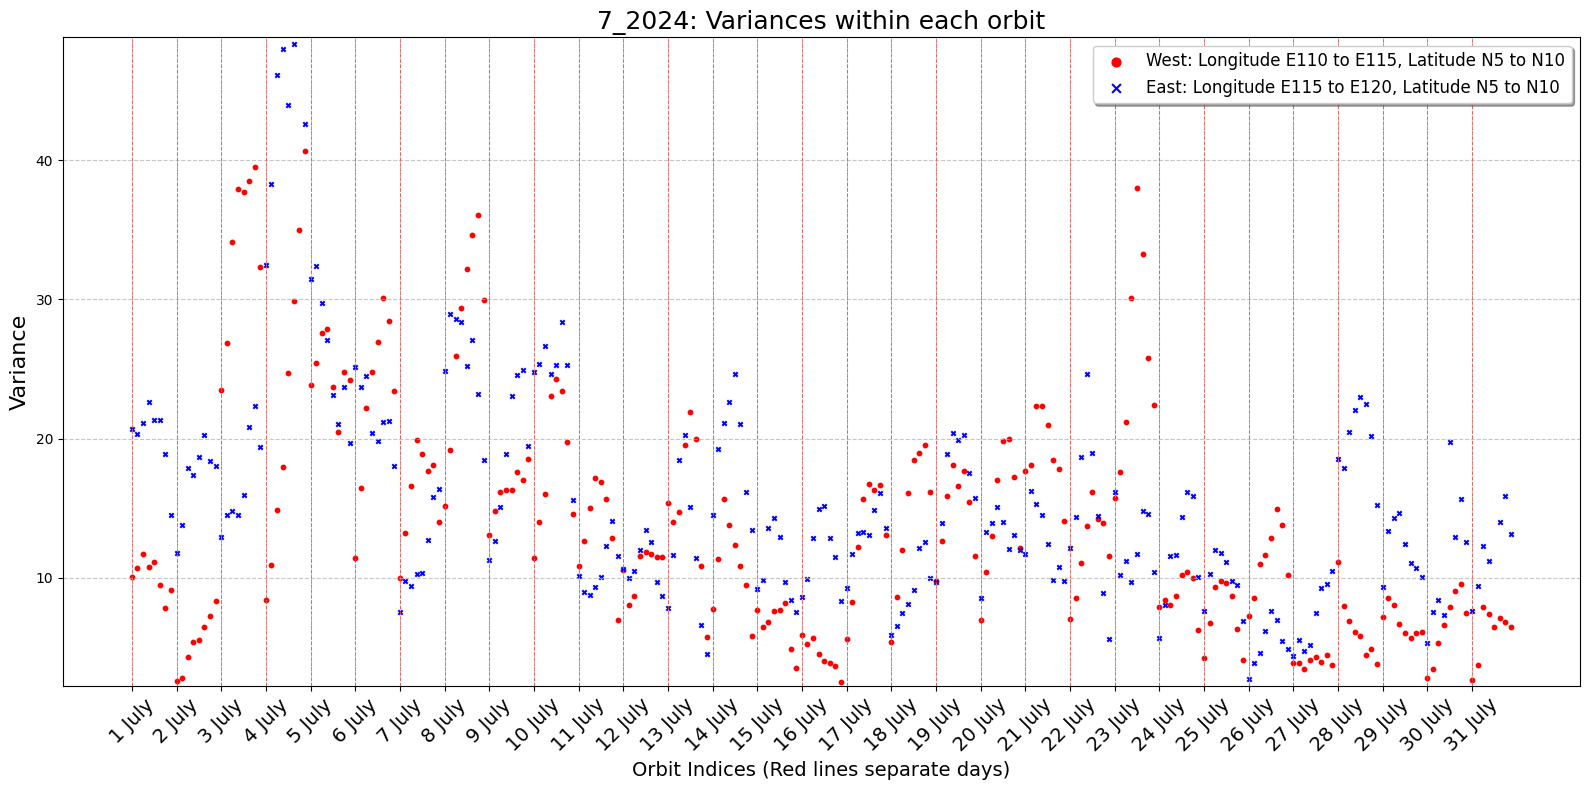

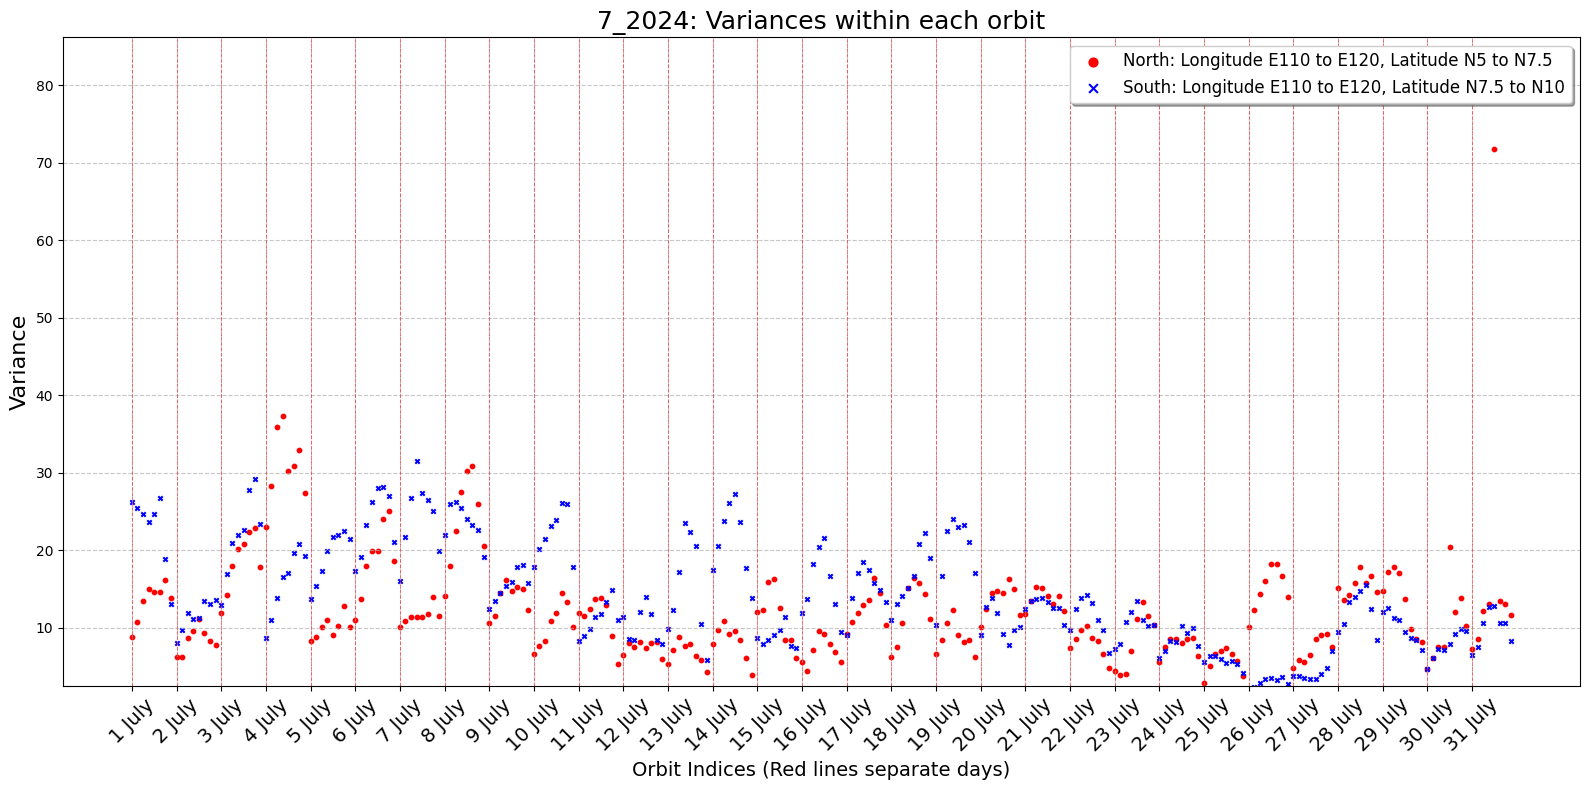

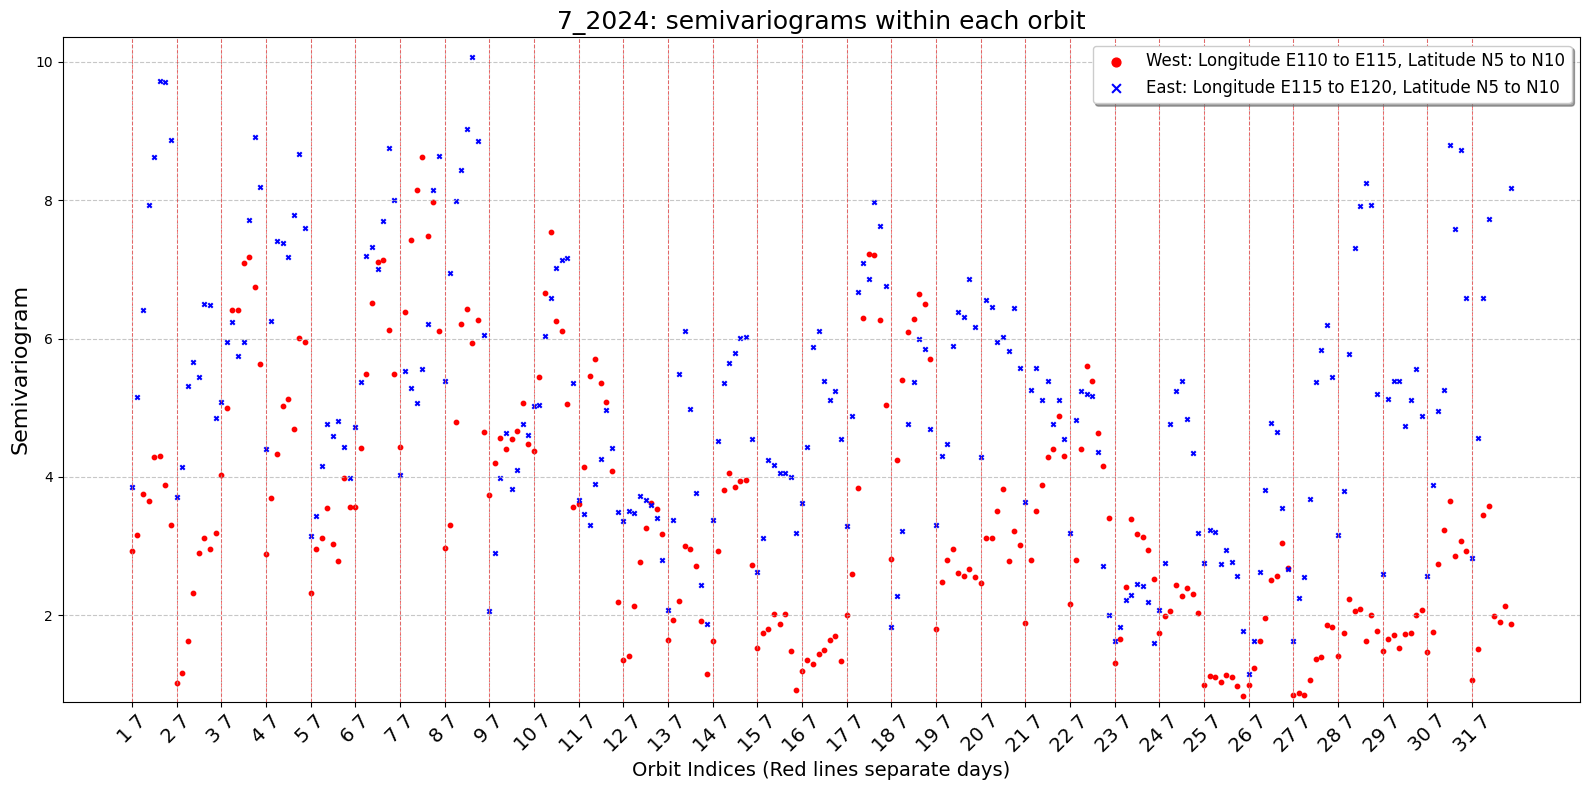

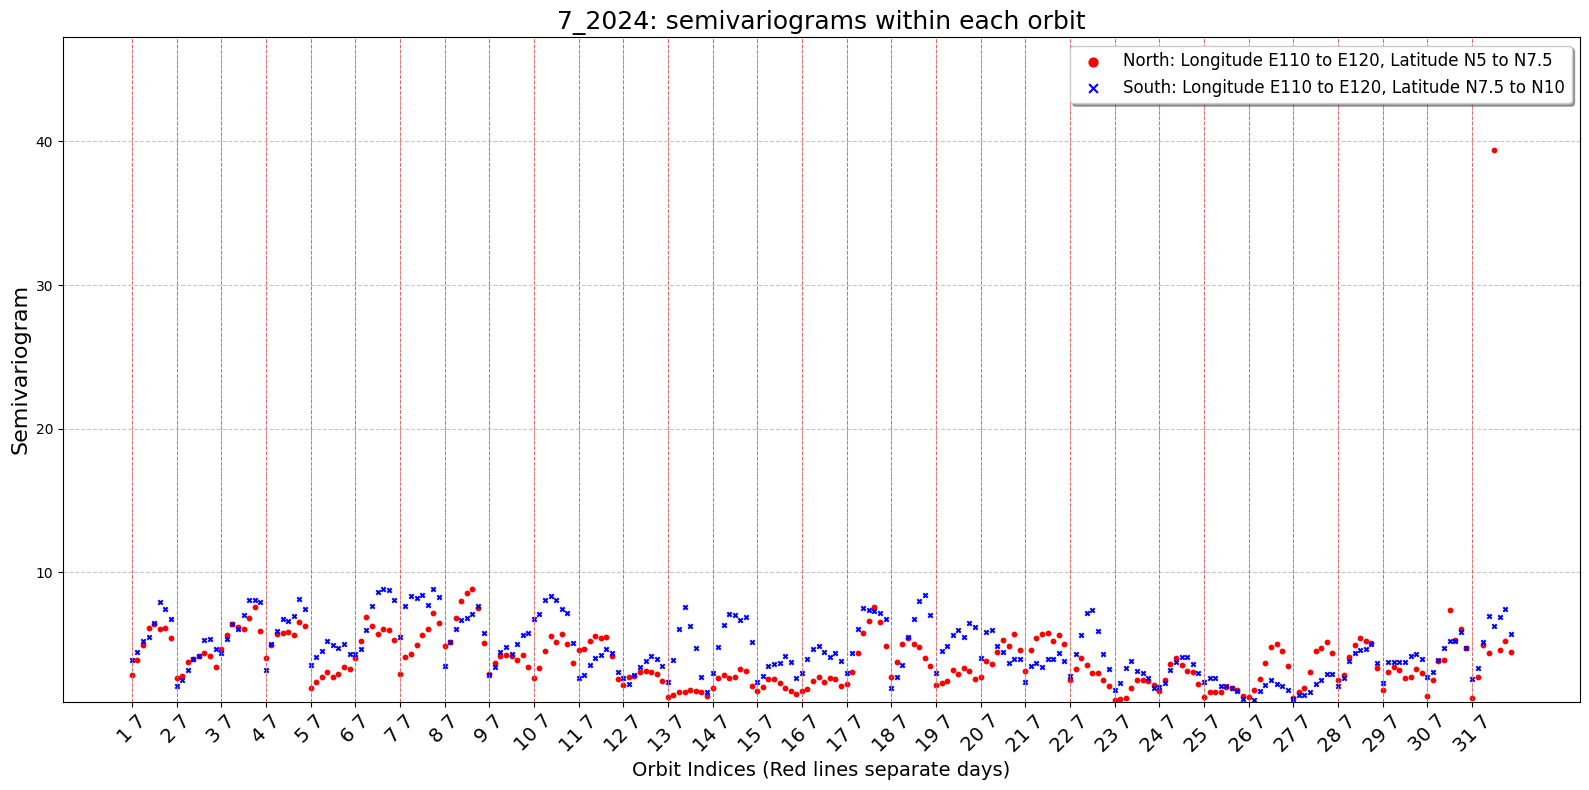

In [5]:
for year in ['2024']:
    for month in range(7,8):
        filepath = f"C:\\Users\\joonw\\TCO\\GEMS_data\\data_{year}\\sparse_cen_map{year[2:]}_{month:02d}.pkl"
        with open(filepath, 'rb') as pickle_file:
            loaded_map = pickle.load(pickle_file)
        
        ''' 
        loaded_map should be a hash map that returns dataframe for 'year' and 'month'.
        '''

        instance_t = timeseries(loaded_map, year, month, output_dir)
        instance_t.save_data_plots()